In [5]:
import os
os.chdir('/home/oban/Desktop/Volga/stellar-classification')
import numpy as np
import pandas as pd
from astropy.io import fits
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import (Dataset, TensorDataset, DataLoader, 
                              WeightedRandomSampler, random_split)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [6]:
hdul = fits.open('data/dataset3_subset2.fits')
hdul1 = fits.open('data/dataset_subset4.fits')
dataset = hdul[1].data
dataset_old = hdul1[1].data
hdul.close()
hdul1.close()

problem = np.where((dataset_old.TYPED_ID == "HD134439") | 
                   (dataset_old.TYPED_ID == "Ross  889"))
dataset_old = np.delete(dataset_old, problem)

In [7]:
# trsvchn's answer on stackoverflow at: https://stackoverflow.com/questions/55588201/pytorch-transforms-on-tensordataset

class CustomTensorDataset(Dataset):
    """TensorDataset with support of transforms.
    """
    def __init__(self, tensors, transform=None):
        assert all(tensors[0].size(0) == tensor.size(0) for tensor in tensors)
        self.tensors = tensors
        self.transform = transform

    def __getitem__(self, index):
        x = self.tensors[0][index]

        if self.transform:
            x = self.transform(x)

        y = self.tensors[1][index]

        return x, y

    def __len__(self):
        return self.tensors[0].size(0)

class GaussianNoise(torch.nn.Module):
    def __init__(self, mean: float, sigma_r: tuple):
        super().__init__()
        self.mean = mean
        self.sigma_r = sigma_r

    def forward(self, spectra):
        sigma = torch.Tensor((1)).uniform_(*self.sigma_r).cuda()
        noise = self.mean + torch.randn_like(spectra).cuda() * sigma
        out = spectra + noise
        return out

def split_dataset(data, label, dataset, split, **kwargs):
    x = data[split]
    y = label[split]
    return dataset((x,y),**kwargs)

In [8]:
flux_numpy = dataset.FLUX.newbyteorder().byteswap()

from eval_utils import label_field, stellar_metrics

label_f = label_field(dataset, regr=False, new=True)
# label_f_old = label_field(dataset_old, regr=False, new=False)

classes = label_f.classes
indices = label_f.ord_to_idx(classes)

splits = list(range(0,len(dataset)))

train, test_val = train_test_split(splits, test_size=0.3, 
                                   random_state=1337, stratify=indices)

ones = np.where(np.unique(classes[test_val],return_counts=True)[1] == 1)

if len(ones) != 0: 
    for i in ones[0]:
        label = label_f.idx_to_ord(i)
        idx = np.where(classes[train] == label)[0][-1]
        real_idx = train.pop(idx)
        test_val.append(real_idx)

val, test = train_test_split(test_val, test_size=0.5, 
                             random_state=1337, stratify=indices[test_val])

assert sum([len(set(classes[i])) for i in [train, val, test]]) % 3 == 0

In [9]:
flux = torch.tensor(flux_numpy).cuda().float()
labels = torch.tensor(indices).cuda().int() #indices

gaussian_noise = GaussianNoise(mean=0,sigma_r=(0.01,0.05))

train_iter = split_dataset(flux, labels, CustomTensorDataset, 
                           train, transform=gaussian_noise)

val_iter = split_dataset(flux, labels, CustomTensorDataset, val)

test_iter = split_dataset(flux, labels, CustomTensorDataset, test)

weights = pd.Series(indices[train]).value_counts()

random_sample = WeightedRandomSampler(weights=max(weights)/weights[indices[train]].values,
                                      num_samples=len(indices[train]))

train_loader = DataLoader(train_iter, 128, sampler=random_sample)
val_loader = DataLoader(val_iter, 16)
test_loader = DataLoader(test_iter, 16)

In [10]:
def trainer(dataloader, model, loss, optimizer):
    losses = []
    preds = []
    actuals = []
    model.train()
    for fluxes, labels in dataloader:

        labels = labels.type(torch.LongTensor).cuda()
        fluxes = fluxes.cuda()

        optimizer.zero_grad()
        class_scores = model(fluxes)
        train_loss = loss(class_scores, labels)
        train_loss.backward()
        optimizer.step()
    
        losses.append(train_loss.item())
        preds.extend(class_scores.argmax(dim=1).tolist())
        actuals.extend(labels.tolist())

    inter_sm = stellar_metrics(label_f, preds, actuals, True, False)
    f1 = inter_sm.f1_macro()
    qwk = inter_sm.two_stage_qwk('q')

    return losses, f1, qwk

def validator(dataloader, model, loss, test=False):
    losses = []
    preds = []
    actuals = []
    model.eval()
    with torch.no_grad():
        if not test:
            for fluxes, labels in dataloader:
                labels = labels.type(torch.LongTensor).cuda()
                fluxes = fluxes.cuda()

                class_scores = model(fluxes)
                val_loss = loss(class_scores, labels)
                losses.append(val_loss.item())
                preds.extend(class_scores.argmax(dim=1).tolist())
                actuals.extend(labels.tolist())

            inter_sm = stellar_metrics(label_f, preds, actuals, True, False)
            f1 = inter_sm.f1_macro()
            qwk = inter_sm.two_stage_qwk('q')

            return losses, f1, qwk

        if test:
            for fluxes, labels in dataloader:
                labels = labels.type(torch.LongTensor).cuda()
                fluxes = fluxes.cuda()

                class_scores = model(fluxes)
                class_preds = class_scores.argmax(dim=1)
                preds.extend(class_preds.tolist())
                actuals.extend(labels.tolist())

            return preds, actuals

class2coords = torch.tensor(
    label_f.to_regr(np.unique(classes),idx=False),
    dtype=torch.float32)

class OrdinalLoss(nn.Module):
    def __init__(self, class2coords, alpha, betas=[1,1]):
        super().__init__()
        # register as a buffer so it moves with .to(device), but is not trained
        self.register_buffer('coords', class2coords)  
        self.alpha = torch.tensor(alpha).cuda()
        self.betas = torch.tensor(betas).cuda()

    def forward(self, logits, target):
        probs = logits.softmax(dim=1)
        pred_xy = probs @ self.coords
        true_xy = self.coords[target]

        loss_xent = F.cross_entropy(logits, target)
        loss_ord = F.mse_loss(self.betas*pred_xy, self.betas*true_xy)
        return (1-self.alpha)*loss_xent + self.alpha*loss_ord

In [11]:
# from torchmetrics.regression import MeanAbsoluteError
from models.conv1d import StarClassifier4

filters = [1,32,128,512,2048,512,128,32]
strides = [1, 2, 2, 2, 2, 2, 2, 2]

model_config = {'filter_sizes':filters,
                'kernels':[3,5,7],
                'strides':strides,
                'output_dim':len(label_f.idx_dict),
                'hidden_dim':2048,
                'dropout':0,
                'input_shape':flux_numpy.shape[-1]}

torch.manual_seed(1337)
torch.cuda.manual_seed(1337)
torch.cuda.manual_seed_all(1337)

classifier = StarClassifier4(**model_config).to('cuda')

custom_loss = OrdinalLoss(class2coords, 0.75, betas=[1,1.5]).cuda()

adamw = torch.optim.AdamW(classifier.parameters(), lr=0.00005, betas=(0.9,0.95))

In [12]:
folder_name = 'final7_starclassifier4_test'
path = f'models/weights/conv1d/cls/{folder_name}'
best_i = 148

classifier3 = StarClassifier4(**model_config).to('cuda')
classifier3.load_state_dict(torch.load(f'{path}/best_conv1d_cls_{best_i}.pth.tar'))

<All keys matched successfully>

In [13]:
def test_time_validator(dataloader, model, n):
    scores = []
    model.eval()
    with torch.no_grad():
        for fluxes, labels in dataloader:
            labels = labels.type(torch.LongTensor).cuda()
            fluxes = torch.roll(fluxes, n).cuda()

            class_scores = model(fluxes)
            scores.append(class_scores)

        return scores

from tqdm import auto

final_scores = []
for shift in auto.tqdm(range(-5,5,1)):
    x = test_time_validator(test_loader, classifier3, shift)
    final_scores.append(x)

  0%|          | 0/10 [00:00<?, ?it/s]

In [14]:
norm_weights = 1/(1 * np.sqrt(2 * np.pi)) * np.exp( - (np.linspace(-3,3,10)**2) ) / (2 * 1**2)
norm_weights = (norm_weights-min(norm_weights))/(max(norm_weights)-min(norm_weights))
norm_weights = np.tile(norm_weights,(39,1)).T

final = torch.stack([torch.cat(x) for x in final_scores],dim=1)
ah = final*torch.tensor(norm_weights).cuda().sum(dim=1).argmax(dim=-1)

In [18]:
final_scores[0][0].shape

torch.Size([16, 39])

In [15]:
final.shape

torch.Size([1295, 10, 39])

In [ ]:
norm_weights = 1/(1 * np.sqrt(2 * np.pi)) * np.exp( - (np.linspace(-3,3,10)**2) ) / (2 * 1**2)
norm_weights = (norm_weights-min(norm_weights))/(max(norm_weights)-min(norm_weights))
norm_weights = np.tile(norm_weights,(39,1)).T

final = torch.stack([torch.cat(x) for x in final_scores],dim=1)
ah = final*torch.tensor(norm_weights).cuda()
ah = ah.sum(dim=1).argmax(dim=-1)

F1 Macro: 61.80%
Mean Absolute Error: 0.18
Q-Weighted Kappa: 97.54%, 61.18%


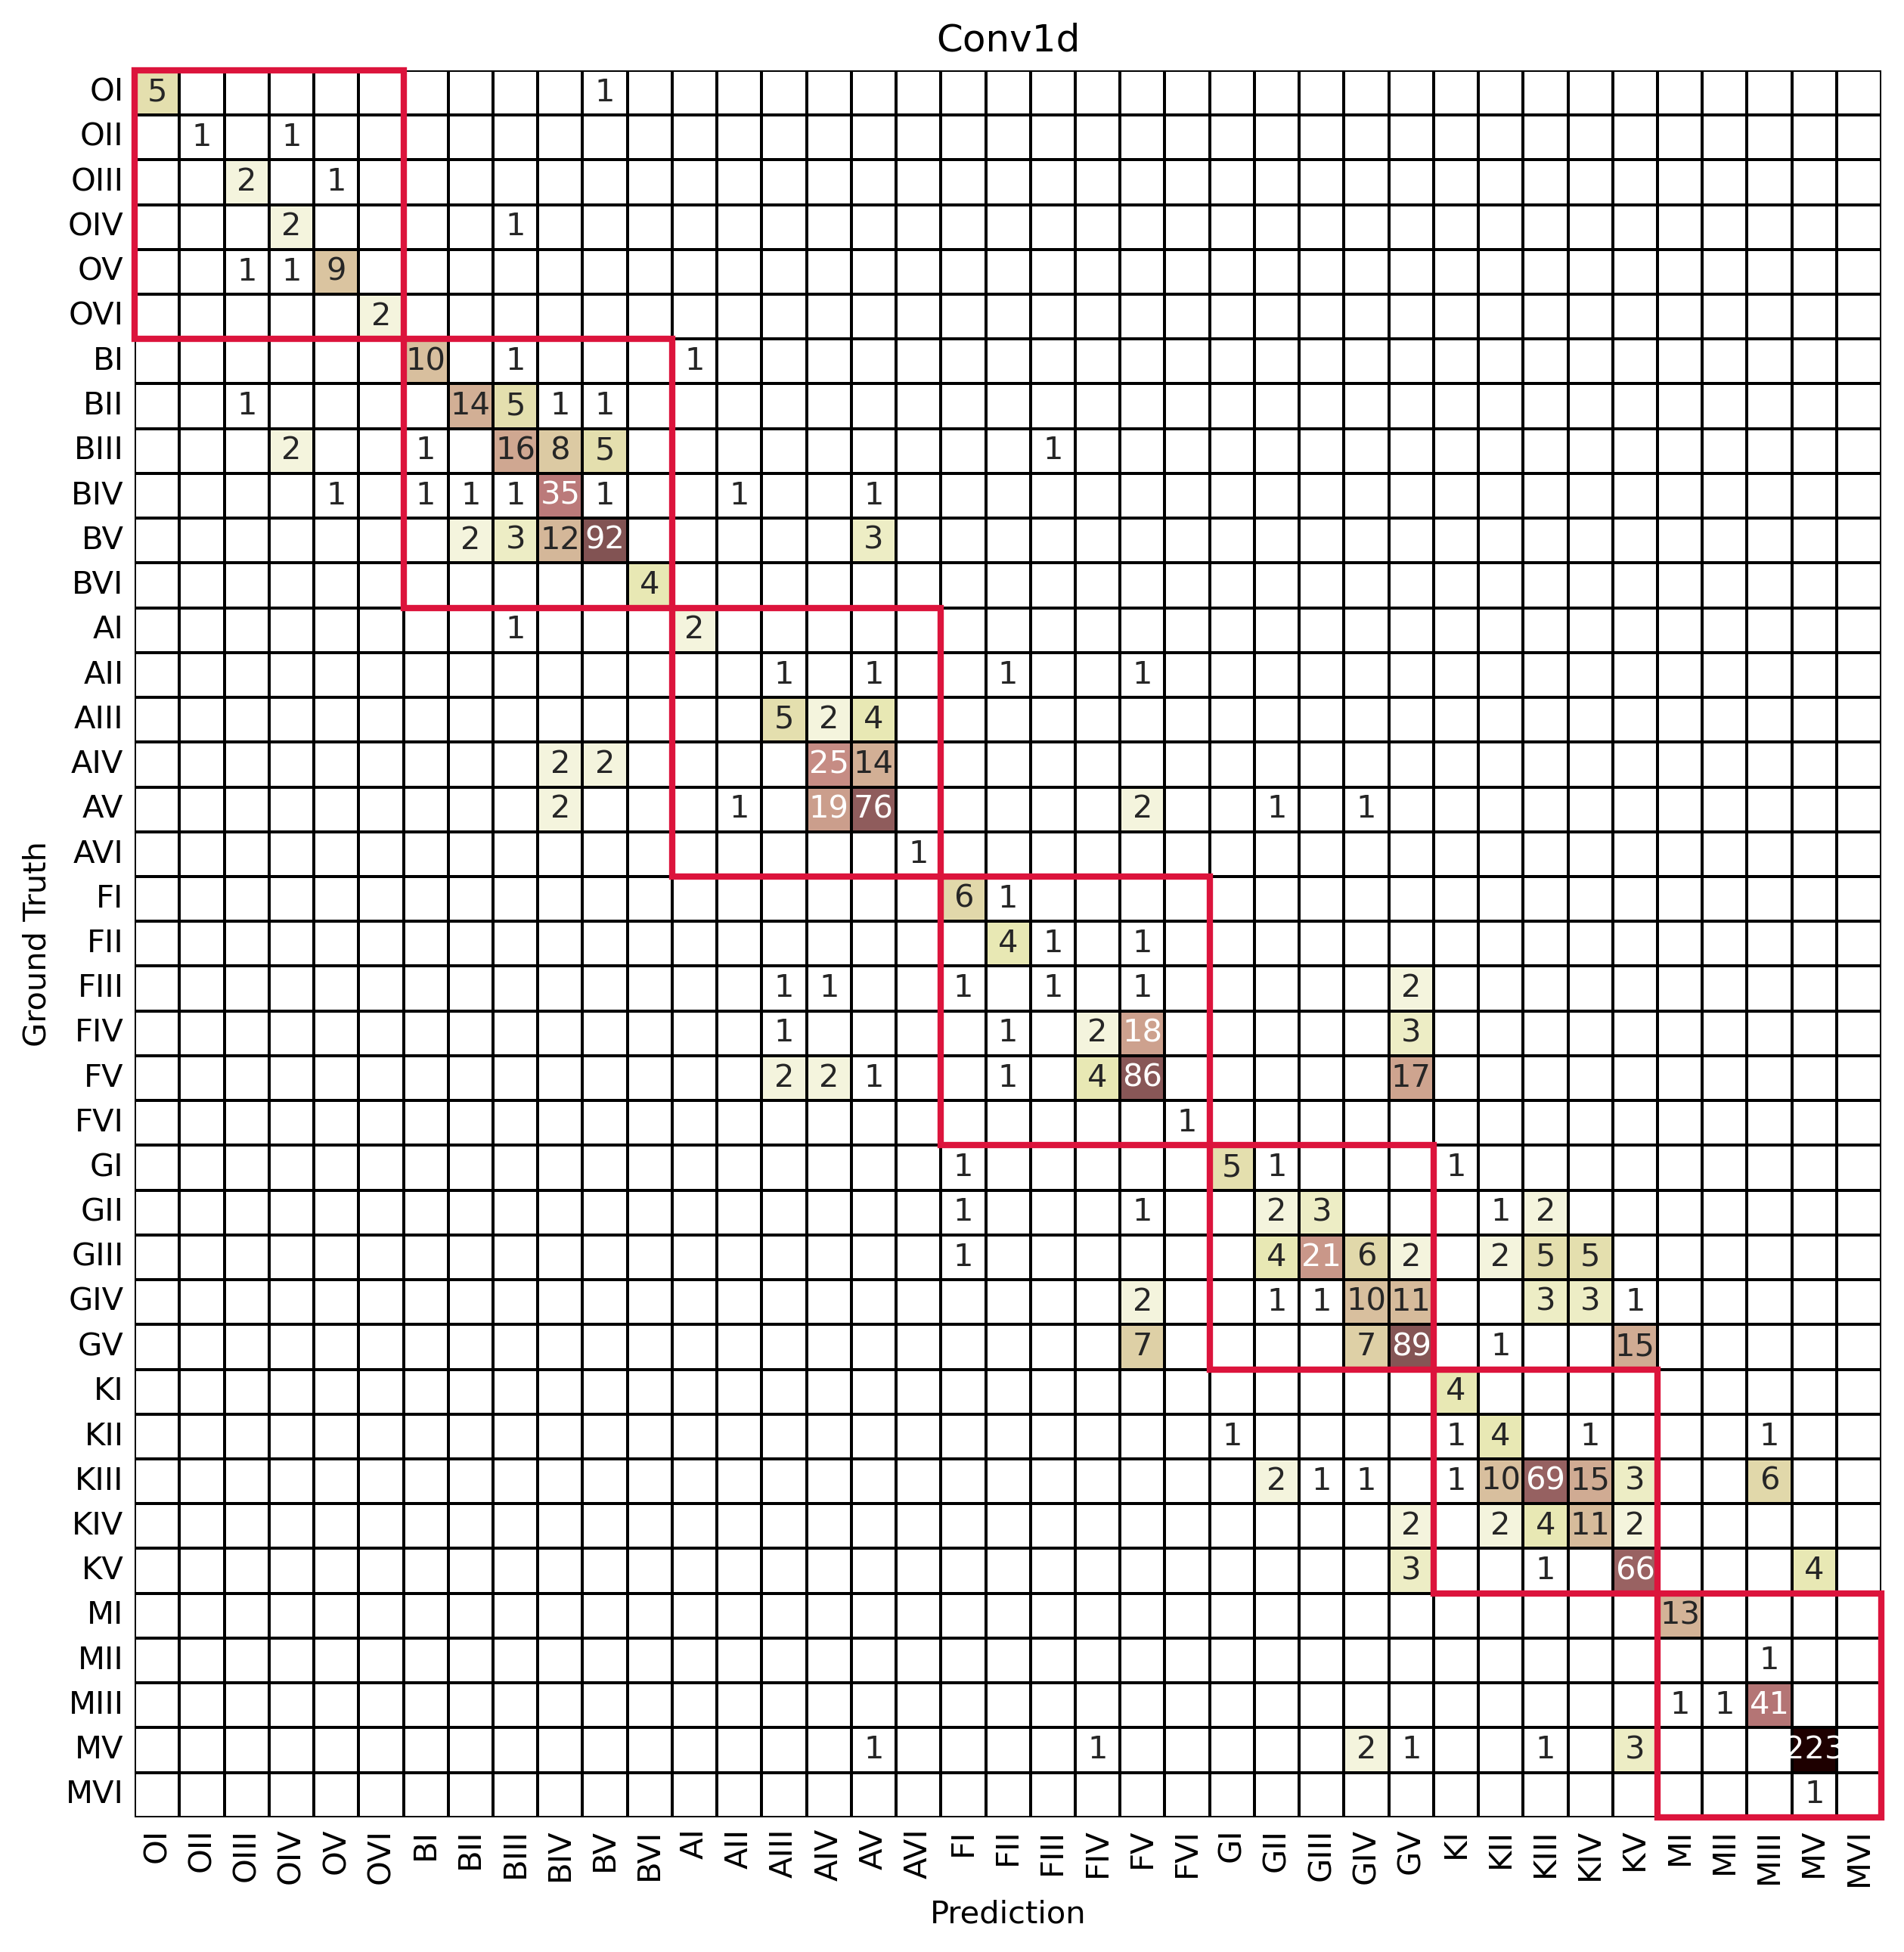

In [ ]:
preds, actuals = validator(test_loader, classifier3, custom_loss, test=True)

pred_aug = list(ah.cpu().numpy())
sm = stellar_metrics(label_f, pred_aug, actuals, True, False)

sm.draw_cm('Conv1d', 300, False)

print(f'F1 Macro: {sm.f1_macro():.2%}')
print(f'Mean Absolute Error: {sm.mae():.2f}')
print(f'Q-Weighted Kappa: {sm.two_stage_qwk("q")[0]:.2%}, {sm.two_stage_qwk("q")[1]:.2%}')

In [ ]:
final.argmax(dim=-1).mode(dim=-1)

torch.return_types.mode(
values=tensor([31, 10, 22,  ..., 15, 14, 26], device='cuda:0'),
indices=tensor([9, 8, 6,  ..., 9, 7, 8], device='cuda:0'))

In [ ]:
final.softmax(dim=-1).argmax(dim=-1).mode(dim=-1)

torch.return_types.mode(
values=tensor([31, 10, 22,  ..., 15, 14, 26], device='cuda:0'),
indices=tensor([9, 8, 6,  ..., 9, 7, 8], device='cuda:0'))

In [ ]:
ah2 = final.argmax(dim=-1).mode(dim=-1).values
pred_aug2 = list(ah2.cpu().numpy())

F1 Macro: 55.24%
Mean Absolute Error: 0.21
Q-Weighted Kappa: 97.24%, 45.21%


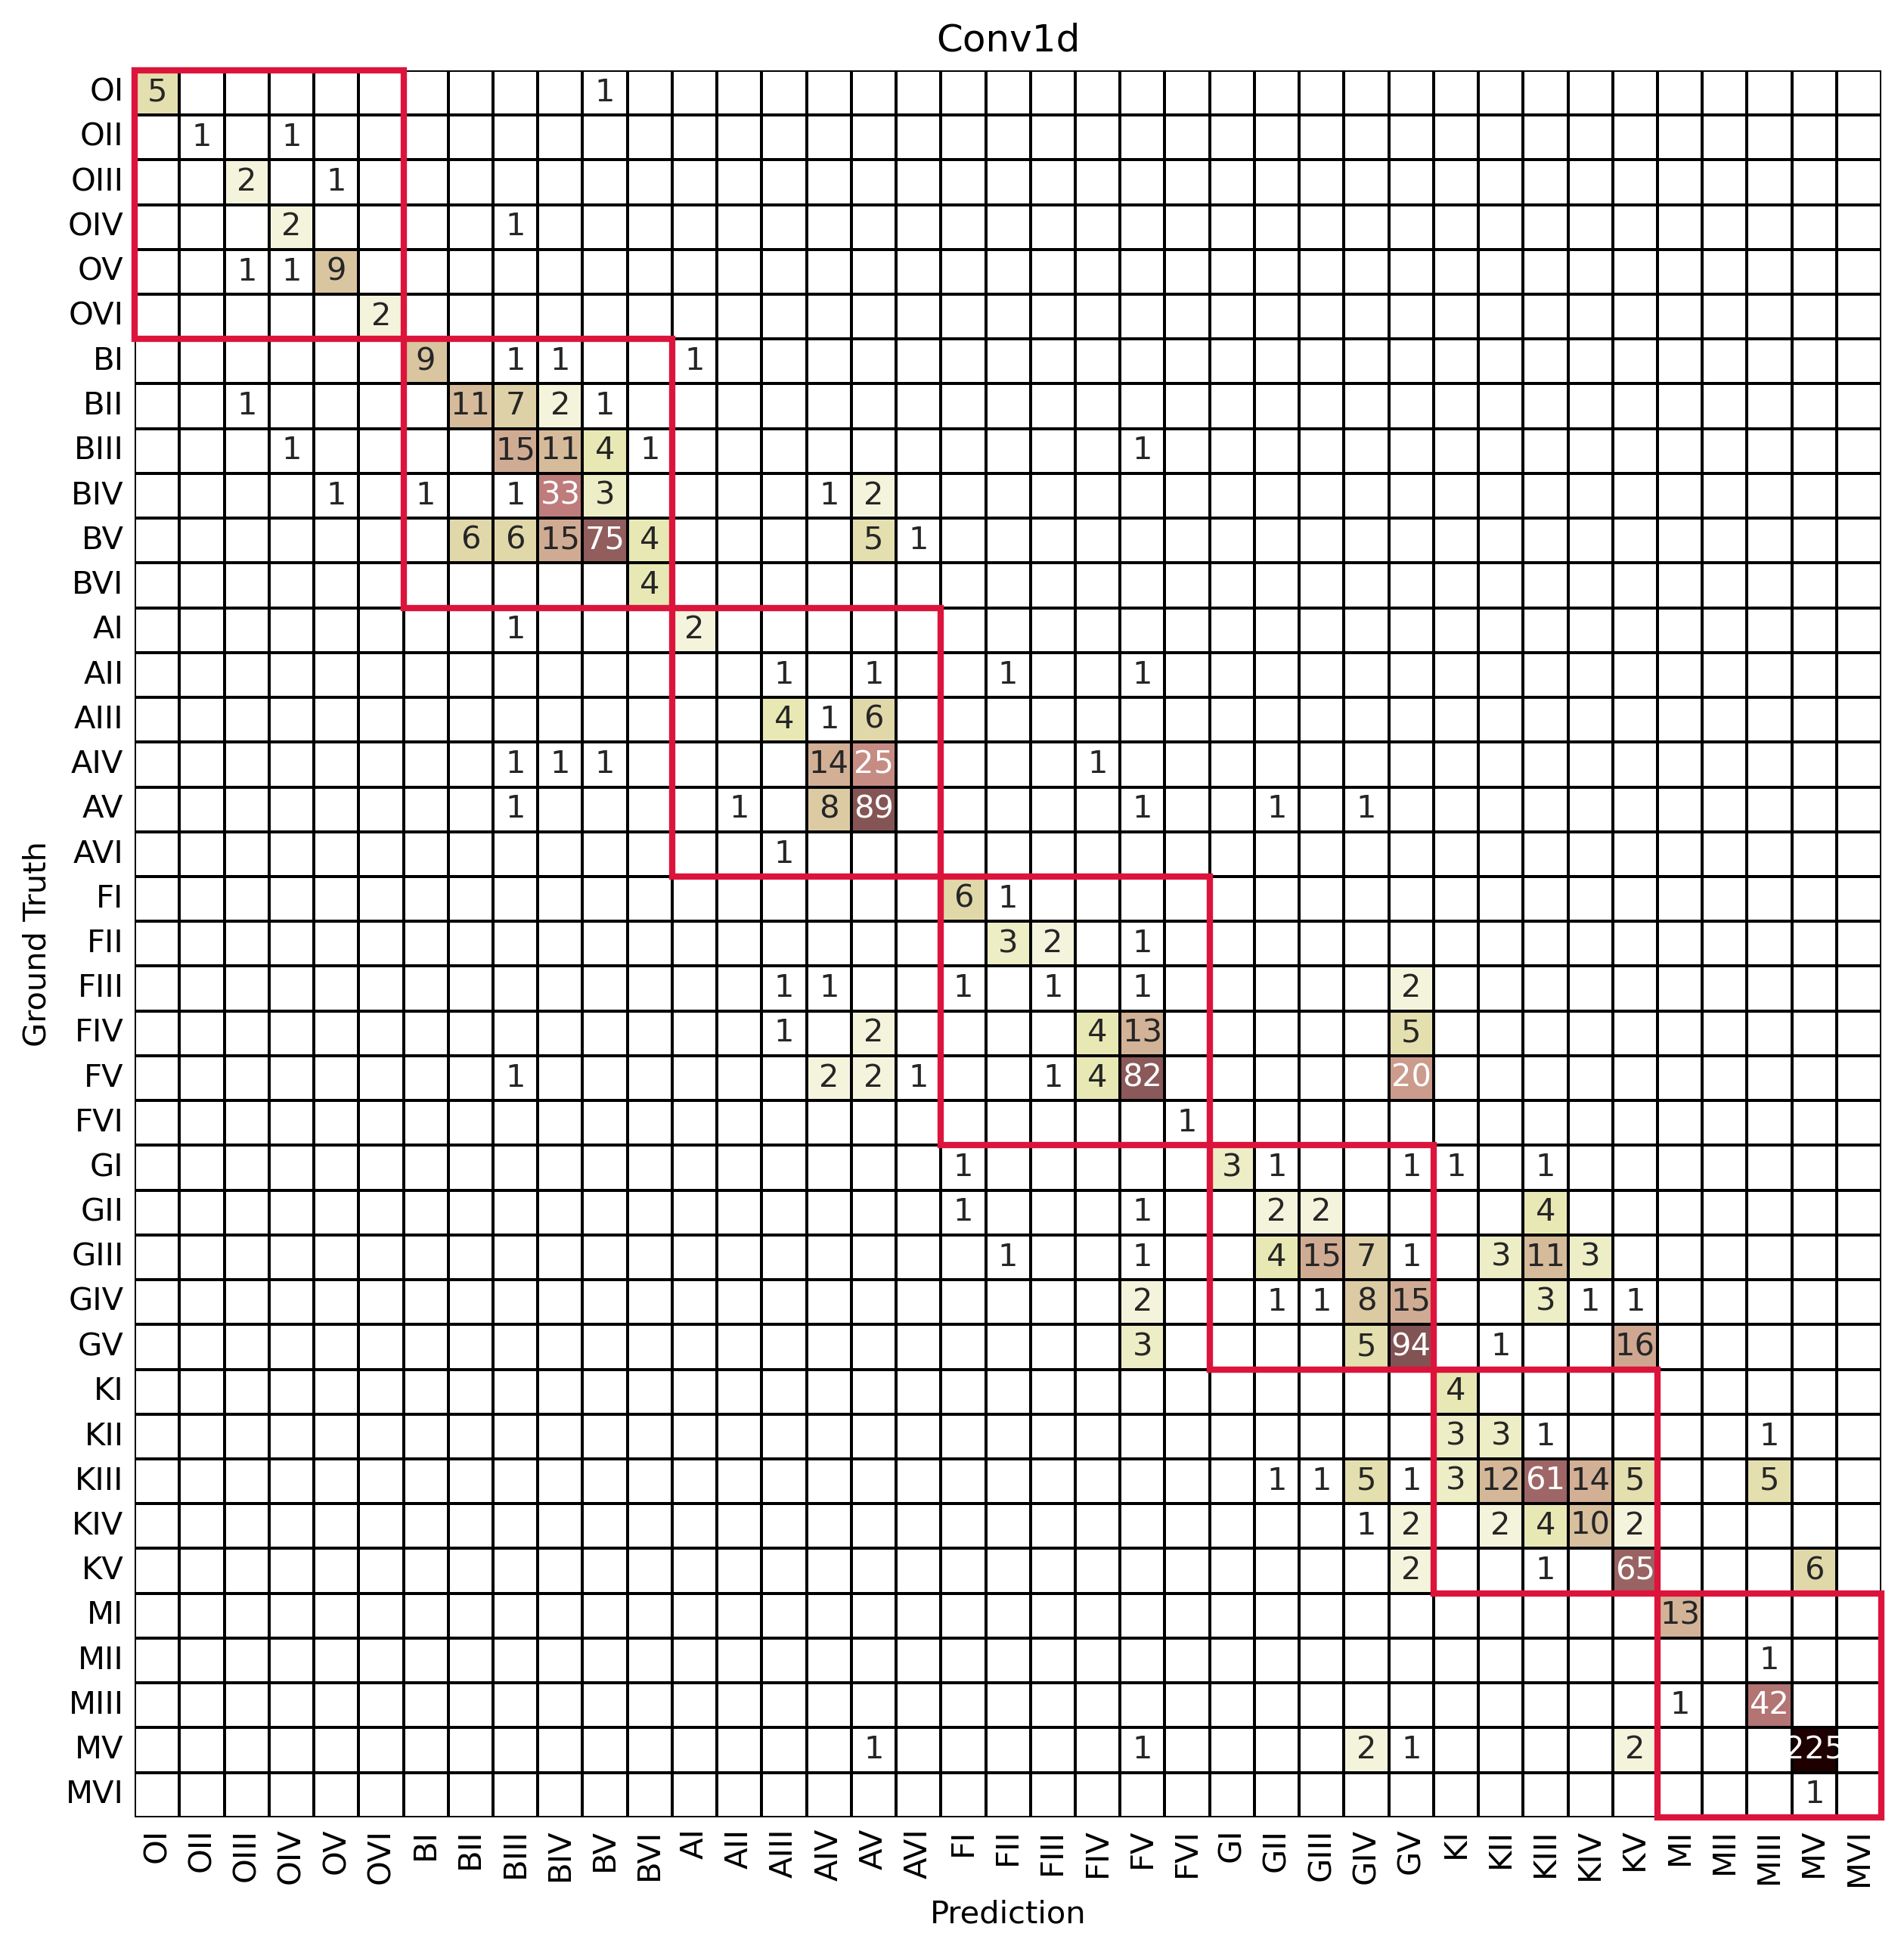

In [ ]:
sm = stellar_metrics(label_f, pred_aug2, actuals, True, False)

sm.draw_cm('Conv1d', 300, False)

print(f'F1 Macro: {sm.f1_macro():.2%}')
print(f'Mean Absolute Error: {sm.mae():.2f}')
print(f'Q-Weighted Kappa: {sm.two_stage_qwk("q")[0]:.2%}, {sm.two_stage_qwk("q")[1]:.2%}')

In [ ]:
flux_numpy.shape

(8622, 2305)

In [ ]:
hdul = fits.open('data/dataset_7000_3.fits')
dataset2 = hdul[1].data
hdul.close()

In [ ]:
dataset2.shape

(15784,)

In [ ]:
dataset2.FLUX.shape

(15784, 7000)

In [ ]:
dataset.DATASET

chararray(['SDSS', 'SDSS', 'SDSS', ..., 'XSL', 'XSL', 'XSL'], dtype='<U6')

In [ ]:
np.unique(dataset.DATASET, return_counts=True)

(chararray(['CFLIB', 'ELODIE', 'SDSS', 'SOPHIE', 'XSL'], dtype='<U6'),
 array([ 805, 3263,  699, 3551,  304]))

In [ ]:
hdul = fits.open('data/dataset_highres_subset.fits')
dataset3 = hdul[1].data
hdul.close()

In [ ]:
dataset3.FLUX.shape

(6334, 55998)

In [ ]:
hdul = fits.open('data/dataset_wide_subset2.fits')
dataset4 = hdul[1].data
hdul.close()

In [ ]:
dataset4.FLUX.shape

(1867, 4174)

In [ ]:
hdul = fits.open('data/dataset3_subset.fits')
dataset5 = hdul[1].data
hdul.close()

In [ ]:
dataset5.FLUX.shape

(10875, 2305)

In [ ]:
np.unique(dataset.DATASET, return_counts=True)

(chararray(['CFLIB', 'ELODIE', 'SDSS', 'SOPHIE', 'XSL'], dtype='<U6'),
 array([ 805, 3263,  699, 3551,  304]))

In [ ]:
np.unique(dataset3.DATASET, return_counts=True)

(chararray(['ELODIE', 'SOPHIE'], dtype='<U6'), array([2994, 3340]))

In [ ]:
np.unique(dataset4.DATASET, return_counts=True)

(chararray(['CFLIB', 'SDSS', 'XSL'], dtype='<U5'), array([794, 743, 330]))